In [1]:
# Libraries for reading, cleaning and plotting the data
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

# Libraries for models 
from sklearn.linear_model import LinearRegression
%matplotlib inline




In [2]:
 df= pd.read_csv("./slr_data.csv")
df.head(3)

,year,sea_level_cm,co2_gt,co2_ppm
0,1971,9.92,15.68,326.32
1,1972,10.14,16.46,327.45
2,1973,10.52,17.44,329.67


In [3]:
df.columns = ["year","sea_level_cm","co2_gt","co2_ppm"]

In [12]:
def linear_model():
    '''This function generates a linear model to predict change in sea level rise in cm (global mean) given historical co2 emissions in gt'''
    # Read in training data 
    df= pd.read_csv("./slr_data.csv")
    df.columns = ["year","sea_level_cm","co2_gt","co2_ppm"]
    #add a variable for change in sea level
    sl_chg =np.diff(df["sea_level_cm"].to_numpy())
    #get the x variable without final year
    ppm_chg = np.diff(df["co2_ppm"].to_numpy())
    #create a new df for co2 emission(x) and change in sea level (y)
    new_df = pd.DataFrame(zip(sl_chg,ppm_chg),columns=["sl_chg","ppm_chg"])
    #create a new df for annual co2 emission(x) and change in co2 concentration (y)
    new_df2 = pd.DataFrame(zip(df["co2_gt"].iloc[0:-1],ppm_chg),columns=["co2_gt","ppm_chg"])
    
    
    fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(15,6))
    #plot the correlation of sea level and annual change in co2 emission (ppm)
    ax1.plot(new_df["ppm_chg"],new_df["sl_chg"])
    ax1.set_xlabel("Annual CO2 Emission Change (ppm)")
    ax1.set_ylabel("Annual Sea Level Change(cm)")

    
    #plot the correlation of sea level and cumulative co2 emission(ppm)
    ax2.plot(df["co2_ppm"],df["sea_level_cm"])
    ax2.set_xlabel("Cum. CO2 Emissions")
    ax2.set_ylabel("Sea Level_cm")
    
    #plot the correlation of co2 annual emission (gt) and change in cumulative co2 emission(ppm)
    ax3.plot(new_df["ppm_chg"],df["co2_gt"].iloc[:-1])
    ax3.set_xlabel("Annual CO2 Emission Change (ppm)")
    ax3.set_ylabel("Annual CO2 Emission (gt)")

    #1-split the data into training and dev datasets
    training_df1 = new_df.sample(frac=0.8)
    dev_df1 = new_df.drop(training_df1.index)

    train_data1 = training_df1["ppm_chg"].to_numpy().reshape(-1,1)
    train_label1 = training_df1["sl_chg"].to_numpy()

    dev_data1 = dev_df1["ppm_chg"].to_numpy().reshape(-1,1)
    dev_label1 = dev_df1["sl_chg"].to_numpy()
    
    #fit a linear model-1
    model1 = LinearRegression()
    model1.fit(train_data1,train_label1)
    
    #2-split the data into training and dev datasets
    training_df2 = df.sample(frac=0.8)
    dev_df2 = df.drop(training_df2.index)

    train_data2 = training_df2["co2_ppm"].to_numpy().reshape(-1,1)
    train_label2 = training_df2["sea_level_cm"].to_numpy()

    dev_data2 = dev_df2["co2_ppm"].to_numpy().reshape(-1,1)
    dev_label2 = dev_df2["sea_level_cm"].to_numpy()
    
    #fit a linear model2
    model2 = LinearRegression()
    model2.fit(train_data2,train_label2)
    
    #3-split the data into training and dev datasets
    training_df3 = new_df2.sample(frac=0.8)
    dev_df3 = new_df2.drop(training_df3.index)

    train_data3 = training_df3["ppm_chg"].to_numpy().reshape(-1,1)
    train_label3 = training_df3["co2_gt"].to_numpy()

    dev_data3 = dev_df3["ppm_chg"].to_numpy().reshape(-1,1)
    dev_label3 = dev_df3["co2_gt"].to_numpy()
    
    #fit a linear model-3
    model3 = LinearRegression()
    model3.fit(train_data3,train_label3)


    pct_sl_chg = (df["sea_level_cm"].iloc[-1]/df["sea_level_cm"].iloc[0])**(1/len(df))
#     #score the model
    print("R2 for annual co2 change and sea level change model: ", model1.score(dev_data1,dev_label1))
    print("R2 for cumulative co2 and sea level model: ", model2.score(dev_data2,dev_label2))
    print("R2 for annual co2 concentration change and annual co2 emission model: ", model3.score(dev_data3,dev_label3))
    return model1, model2, model3, pct_sl_chg

R2 for annual co2 change and sea level change model:  0.01125065964135874
R2 for cumulative co2 and sea level model:  0.9664318798912281
R2 for annual co2 concentration change and annual co2 emission model:  0.15476648262642123


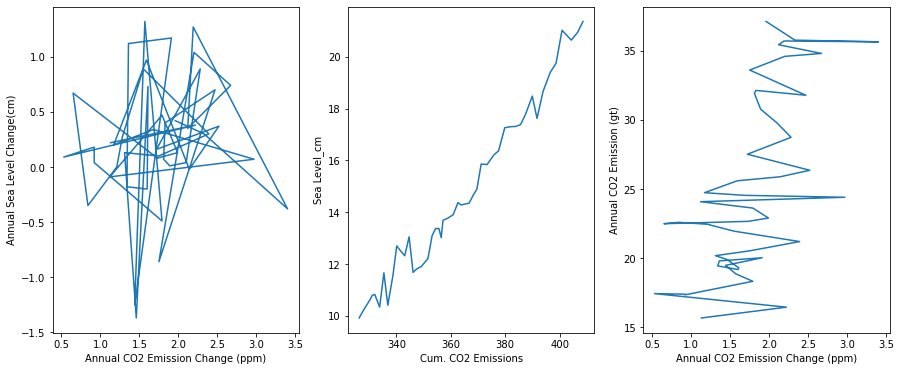

In [13]:
model_chg, model_cum, model_gt, annual_sl_chg = linear_model()

In [15]:
def gen_ppm(gt):
    base_line_ppm = 408.52 #2018 global co2 emission in ppm
    return base_line_ppm + round(float(model_gt.predict(np.array(gt).reshape(-1,1))),2)

In [16]:
def gen_slr(yr=2100,gt=-2.342):
    '''This function takes a co2 emission in gt, a year and gives slr change in meters by that year'''
    #predicts global mean sea level rise in meters.
    base_line_sl = 21.36 #2018 global mean sea level
    base_line_ppm = 408.52 #2018 global co2 emission in ppm
    num_years = yr - 2018
    ppm = gen_ppm(gt)
    if ppm <= base_line_ppm:
        return np.ceil(0.001*annual_sl_chg**num_years)#put a minimal sl rise(1mm) in case of very low emissions 
    else:
        return np.ceil(float(model_cum.predict(np.array([ppm]).reshape(-1,1)) - base_line_sl)/100*annual_sl_chg**num_years)

In [17]:
model_gt.coef_

array([6.43503112])

In [ ]:
gen_slr(2500,0)

In [18]:
model_gt.intercept_

13.805539142685898

In [ ]:
 model_gt.predict([[2]])

In [ ]:
gen_ppm(2)

In [19]:
annual_sl_chg

1.0161068196696892

In [20]:
model_cum.coef_

array([0.13568435])

In [21]:
model_cum.intercept_

-34.709028904357076

base_line_sl = 21.36 
base_line_ppm = 408.52
num_years = yr - 2018

function gen_slr(cum_co2_chg,num_yrs) {
if (13.806+6.435*cum_co2_chg<0){
0.001*1.016**num_yrs};
else {(-34.709+(13.806+6.435*cum_co2_chg+base_line_ppm)*0.136-base_line_sl)/100*1.016**num_yrs}
}

In [22]:
13.81/6.44

2.1444099378881987